In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
# _sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_sh = _gc.open('Opto_log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

#### Functions

In [6]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

### Define data path

In [7]:
rec_folder = r'M:\opto_pilot\mouse707966\optoCT_estim_2024-01-12_10-36-44\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

This data does not contain an EEG recording.
Experiment type: electrical stimulation


In [8]:
exp.experiment_data

['probeC_sorted', 'probeD_sorted', 'probeF_sorted']

In [9]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

In [10]:
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

optoCT_estim


#### Load stim table and get good EEG channels

In [11]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
0,estim,0,biphasic,40,200.58721,200.58761,0.0004,0
1,estim,1,biphasic,40,205.80095,205.80135,0.0004,0
2,estim,2,biphasic,40,212.72519,212.72559,0.0004,0
3,estim,3,biphasic,40,217.73489,217.73529,0.0004,0
4,estim,4,biphasic,40,224.28515,224.28555,0.0004,0


In [12]:
sweep_labels = {0: 'estim only', 1: 'estim + opto (125ms)', 2: 'estim + opto (75ms)', 3: 'opto only'}

#### Load unit data

In [13]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeC', 'probeD', 'probeF']


In [14]:
## List probes: region labels in order from top to bottom ##
regions = {'probeF': 'ACA <---> MOs', 'probeD': 'SM-TH? <-> VIS?', 'probeC': 'SM-TH? <-> VIS?'}
# regions = {'probeB': 'MOs', 'probeC': 'V1/LGN'}
# regions = {'probeF': 'MOs', 'probeB': 'VM/VAL', 'probeD': 'V1/LGN'}

In [15]:
which_units = 'all' # can choose 'all', 'ctx'

In [16]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        if which_units == 'ctx':
            ## determine cortical units ##
            ctx_mask = np.zeros_like(all_units, dtype=bool)
            for uai, areai in enumerate(all_units_areas):
                if areai != 'null':
                    if 315 in str_tree.get_structures_by_acronym([areai])[0]['structure_id_path']:
                        ctx_mask[uai] = True
            probe_unit_data[probei]['units'] = all_units[ctx_mask]
            probe_unit_data[probei]['areas'] = all_units_areas[ctx_mask]
            probe_unit_data[probei]['chs'] = all_units_chs[ctx_mask]
            total_units += len(probe_unit_data[probei]['units'])
        else:
            probe_unit_data[probei]['units'] = all_units
            probe_unit_data[probei]['areas'] = all_units_areas
            probe_unit_data[probei]['chs'] = all_units_chs
            total_units += len(probe_unit_data[probei]['units'])
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
        probe_unit_data[probei]['units'] = all_units
        probe_unit_data[probei]['chs'] = all_units_chs
        total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeC
 surface channel: 350
 unit count: 206
probeD
 surface channel: 320
 unit count: 47
probeF
 surface channel: 310
 unit count: 350
Total unit count: 603


## Average responses

### Loop through stimuli, one sweep only

In [17]:
before_event = 0.2 # time before event, s
after_event = 1.2 # time after event, s

## Unit params ##
plot_timebin = 0.005 # s

In [18]:
unit_rates = {}
unit_zscores = {}

sweep_list = np.unique(stim_log.sweep.values)
for sweepi in sweep_list:
    start = time.time()
    
    ## Get events ##
    sweep_log = stim_log[stim_log['sweep'] == sweepi]
    if 'estim' in sweep_log.iloc[0]['event_type']:
        events = sweep_log[sweep_log['stim_type'] == 'biphasic'].onset.values
    else:
        events = sweep_log[sweep_log['stim_type'] == '470nm'].onset.values
    
    ## Get mean speed ##
#     rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
#     event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
#     mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
#     rest_events = np.nonzero(mean_speed < 0.5)[0]
#     print('{} state: resting trials {:d}/{:d}'.format(plstate, len(rest_events), len(state_events)))
    
    ## Units ##
    # get evoked firing rates for all units
    unit_rates[sweepi] = {}
    unit_zscores[sweepi] = {}
    total_units = 0
    for probei, unit_data in probe_unit_data.items():
        event_trig_FR, spikerate_ts = get_evoked_firing_rates(
            unit_data['spike_times'],
            unit_data['spike_clusters'],
            unit_data['units'],
            events, # events[rest_events]
            before_event,
            after_event,
            plot_timebin
        )
        # get zscore
        event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, spikerate_ts)

        unit_rates[sweepi][probei] = [spikerate_ts, event_trig_FR]
        unit_zscores[sweepi][probei] = [spikerate_ts, event_trig_Z]
        total_units += event_trig_FR.shape[1]
    
    end = time.time()
    print('{}: {:.2f} s'.format(sweepi, (end - start)))

0: 13.63 s
1: 13.71 s
2: 13.17 s
3: 12.84 s


Plot all with z-score

<IPython.core.display.Javascript object>


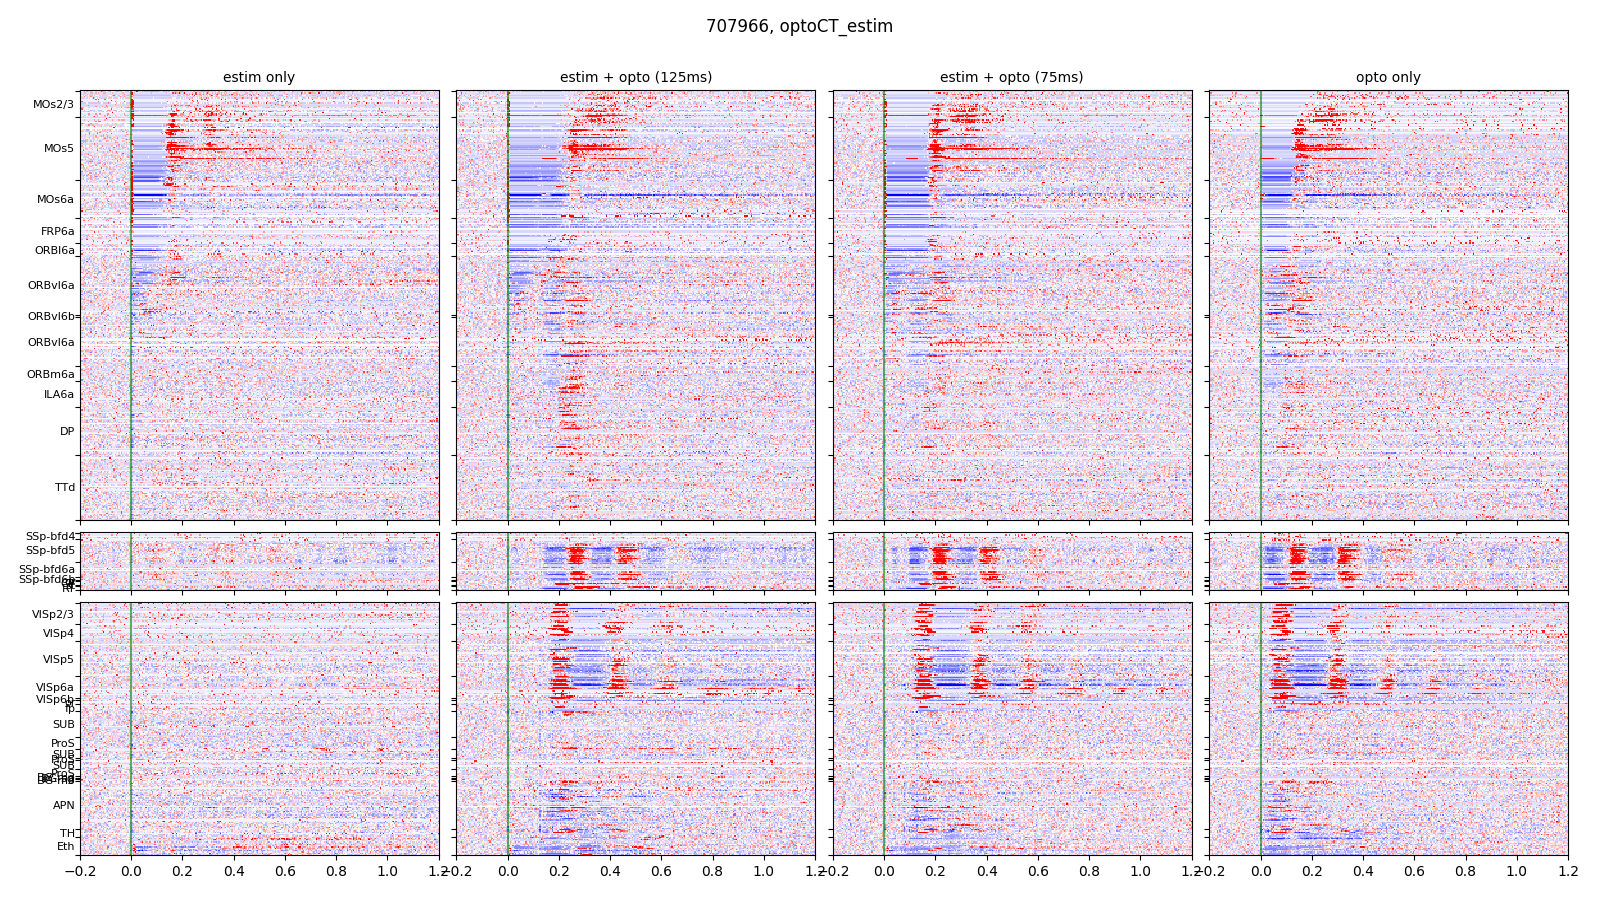

In [19]:
y_limit = 150
set_Zrange = 5

fig = plt.figure(figsize=(16,9)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(
    ncols=(len(sweep_list)), nrows=1,
    left=0.05, right=0.98, top=0.9, bottom=0.05, hspace=0.05, wspace=0.05
)

for sweepi in sweep_list:

    ## Unit z-score, all probes ##
    gs_units = gs[0,sweepi].subgridspec(
        ncols=1, nrows=len(unit_zscores[sweepi].keys()),
        height_ratios=[len(probe_unit_data[x]['units']) for x in regions.keys()], hspace=0.05
    )

    for ii, probei in enumerate(regions.keys()):
        zscoredata = unit_zscores[sweepi][probei]
        axzsc = fig.add_subplot(gs_units[ii])
        units_plot = axzsc.imshow(
            zscoredata[1],
            cmap='bwr',
            interpolation='none',
            aspect='auto',
            origin='lower',
            vmin=-set_Zrange,
            vmax=set_Zrange,
            extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
        )
        axzsc.axvline(0, color='g', alpha=0.6)
        if ii == 0:
            axzsc.set_title(sweep_labels[sweepi])
    
        if probe_unit_data[probei]['areas_assigned']:
            if sweepi == 0:
                ## get area labels ##
                area_boundaries = []
                area_labels = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        area_labels.append(area)
                        last_area = area
                area_boundaries.append(ai)
                label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
                axzsc.set_yticks(label_locs, minor=True)
                axzsc.set_yticklabels(area_labels, minor=True, fontsize=8)
                axzsc.tick_params(which='minor', length=0)
            else:
                ## get area labels ##
                area_boundaries = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        last_area = area
                area_boundaries.append(ai)
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
        else:
            if sweepi == 0:
                unit_depths = probe_unit_data[probei]['ch_depths'][probe_unit_data[probei]['chs']]
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels(unit_depths[np.arange(0, len(probe_unit_data[probei]['units']), 50)]/1000)
                axzsc.annotate(
                    '{}\n{}'.format(probei, regions[probei]),
                    xy=(-0.17, 0.5),
                    xycoords='axes fraction',
                    horizontalalignment='center',
                    verticalalignment='center',
                    rotation='vertical',
                    fontsize=12
                )
            else:
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels('')
        if ii < len(regions)-1:
            axzsc.set_xticklabels('')
    plt.suptitle('{}, {}'.format(exp.mouse, exp_tag))

### SAVE ###
figname = '{}_{}unitzcore_{:d}msbin.png'.format(exp_tag, which_units, int(plot_timebin*1000))
fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

Loop through sweeps, one stim only

Plot all with z-score

### Loop through all amps, chosen sweeps

In [ ]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic', 'circle'
amp_list = sorted(stim_log[stim_log['stim_type']==stim_type].parameter.unique(), key=lambda x: int(x))
print(amp_list)

before_event = 1.0 # time before event, s
after_event = 1.0 # time after event, s

## EEG params ##
apply_mask = True
apply_car = True

## Unit params ##
plot_timebin = 0.001 # s

In [ ]:
unit_rates = {}
unit_zscores = {}

for expdes in fullPCI.keys():

for ampi in amp_list:
    start = time.time()
    
    state_events = []
    for sweepi in state_sweeps[plstate]:
        events = get_stim_events(stim_log, stim_type, plamp, sweepi)
        if len(events) == 0:
            continue
        state_events.append(events)
    state_events = np.concatenate(state_events)

    ## Get mean speed ##
    rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
    event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
    mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
    rest_events = np.nonzero(mean_speed < 0.5)[0]
    print(' {} state: resting trials {:d}/{:d}'.format(plstate, len(rest_events), len(state_events)))

    
    
    ## EEG traces ##
    events = get_stim_events(stim_log, stim_type, ampi, sweep)
    eeg_event_traces, eeg_event_ts = get_evoked_traces(
        eeg_data,
        eeg_ts,
        events,
        before_event,
        after_event,
        exp.ephys_params['EEG']['sample_rate']
    )
    ## Common average reference ##
    if apply_car:
        eeg_event_traces = eeg_event_traces - np.mean(eeg_event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        
    ## Design and apply Butterworth filter ##
    filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
    EEG_traces[ampi] = [eeg_event_ts, np.mean(signal.filtfilt(filtb, filta, eeg_event_traces, axis=0), axis=2)]
    
    
    ## Units ##
    # get evoked firing rates for all units
    unit_rates[ampi] = {}
    unit_zscores[ampi] = {}
    total_units = 0
    for probei, unit_data in probe_unit_data.items():
        event_trig_FR, spikerate_ts = get_evoked_firing_rates(
            unit_data['spike_times'],
            unit_data['spike_clusters'],
            unit_data['units'],
            events,
            before_event,
            after_event,
            plot_timebin
        )
        # get zscore
        event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, spikerate_ts)

        unit_rates[ampi][probei] = [spikerate_ts, event_trig_FR]
        unit_zscores[ampi][probei] = [spikerate_ts, event_trig_Z]
        total_units += event_trig_FR.shape[1]
    
    end = time.time()
    print('{}: {:.2f} s'.format(ampi, (end - start)))

Plot all with z-score

In [ ]:
y_limit = 50
set_Zrange = 5

fig = plt.figure(figsize=(16,9)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(
    ncols=(len(amp_list)), nrows=2, height_ratios=[1,4],
    left=0.05, right=0.98, top=0.9, bottom=0.05, hspace=0.05, wspace=0.05
)

for i, ampi in enumerate(amp_list):
    ## EEG butterfly plot ##
    axeeg = fig.add_subplot(gs[0,i])
    axeeg.plot(EEG_traces[ampi][0], EEG_traces[ampi][1][:,GOOD_CHS], 'k', linewidth=0.8, alpha=0.8)
    axeeg.set_xlim([EEG_traces[ampi][0][0], EEG_traces[ampi][0][-1]])
    axeeg.set_ylim(-y_limit, y_limit)
    axeeg.axvline(0, color='g', alpha=0.6)
    axeeg.set_title('{} \u03bcA'.format(ampi))
    axeeg.set_xticklabels('')
    if i == 0:
        axeeg.set_ylabel('Voltage (\u03BCV)')
    else:
        axeeg.set_yticklabels('')

    ## Unit z-score, all probes ##
    gs_units = gs[1,i].subgridspec(
        ncols=1, nrows=len(unit_zscores[ampi].keys()),
        height_ratios=[len(probe_unit_data[x]['units']) for x in regions.keys()], hspace=0.05
    )

    for ii, probei in enumerate(regions.keys()):
        zscoredata = unit_zscores[ampi][probei]
        axzsc = fig.add_subplot(gs_units[ii])
        units_plot = axzsc.imshow(
            zscoredata[1],
            cmap='bwr',
            interpolation='none',
            aspect='auto',
            origin='lower',
            vmin=-set_Zrange,
            vmax=set_Zrange,
            extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
        )
        axzsc.axvline(0, color='g', alpha=0.6)
    
        if probe_unit_data[probei]['areas_assigned']:
            if i == 0:
                ## get area labels ##
                area_boundaries = []
                area_labels = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        area_labels.append(area)
                        last_area = area
                area_boundaries.append(ai)
                label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
                axzsc.set_yticks(label_locs, minor=True)
                axzsc.set_yticklabels(area_labels, minor=True, fontsize=8)
                axzsc.tick_params(which='minor', length=0)
            else:
                ## get area labels ##
                area_boundaries = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        last_area = area
                area_boundaries.append(ai)
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
        else:
            if i == 0:
                unit_depths = probe_unit_data[probei]['ch_depths'][probe_unit_data[probei]['chs']]
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels(unit_depths[np.arange(0, len(probe_unit_data[probei]['units']), 50)]/1000)
                axzsc.annotate(
                    regions[probei],
                    xy=(-0.12, 0.5),
                    xycoords='axes fraction',
                    horizontalalignment='center',
                    verticalalignment='center',
                    rotation='vertical',
                    fontsize=12
                )
            else:
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels('')
        if ii < len(regions)-1:
            axzsc.set_xticklabels('')
    plt.suptitle('{}, {}'.format(exp.mouse, sweep_states[sweep]))

### SAVE ###
figname = '{}_{}unitzcore_eeg_{}_allamps_{:d}ms.png'.format(exp_tag, which_units, sweep_states[sweep], int(plot_timebin*1000))
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

Separate resting/running

Plot all with z-score